# DTEK0042 Exercise 4
    Group Members:
    1. Tristan Deenen
    2. Anna Fernandez-Rajal i Sabala
    3. Irene Torrijos Robles

*** Note for Google Colab Users ***
     Because Google Colab doesn't have a button to convert your notebook to .html format here is a quick work around:
   1. open a new google colab notebook
   2. in the files section in google colab, upload the .ipynb file you want to be converted to .html
   3. in your new open notebook run this command in an empty cell: !jupyter nbconvert --to html YourFileName.ipynb
   4. after the command is finished running refresh the page
   5. In your files section you should see your original .ipynb file that you uploaded and then a .html file of that same notebook.
   6. download the .html file and you're good to go!

In this exercise, you are required to analyze a SCG signal step-by-step as outlined below.  The deliverables for this exercise are a jupyter notebook and a .html file exported form the notebook. The notebook should includes your code, observations, graphs, and conclusions made upon analyzing the given SCG signals. Please provide caption and description for every figure. 

## 1- library Imports

In [33]:
#scipy imports
#import scipy 
from scipy import signal, stats
#from scipy.signal import butter, filtfilt, freqz

#numpy imports
import numpy as np

#matplotlib imports
import matplotlib.pyplot as plt

#sklean imports
from sklearn.decomposition import PCA
from sklearn import preprocessing as prep
#other imports
from glob import glob

# Data Import 
* Load the .txt files of SCG data that are stored in the folder named “dataset” into your python environment.  
* For each .txt data file, select the 3rd column which contains the Z-axis of the SCG signals. 
* Note: the sampling frequency of this signal is 200 Hz. 

        Hint:  
        * to automate the loading process you can get a list of all data file paths using glob package and subsequently load the files in a for loop. 
        
        * dataFiles = glob.glob(path_to_dataset) to get a list of file paths of "dataset\xxdata.txt"
        
         then load the paths one by one in a loop

In [34]:
import pandas as pd

fs=200 #sampling freq

path_to_dataset = 'dataset/'

dataFiles = glob(path_to_dataset + '*.txt')
z_axis_data = pd.DataFrame()

for data_file in dataFiles:
    
    df = pd.read_csv(data_file, sep=' ', header=None)
    column_name = data_file.split('/')[-1]
    z_axis_data[column_name] = df.iloc[:, 2]

# dataframe where each column is the z-axis data of a sensor, and the column name is the file name

# Noisy Vs Normal Plotting

* Plot the z-axis SCG signal from the file "Noisy_data_1.txt" and plot the z-axis SCG signal from the file "Normal_data_1.txt" 
* Describe your observations and how the plots differ from one another.


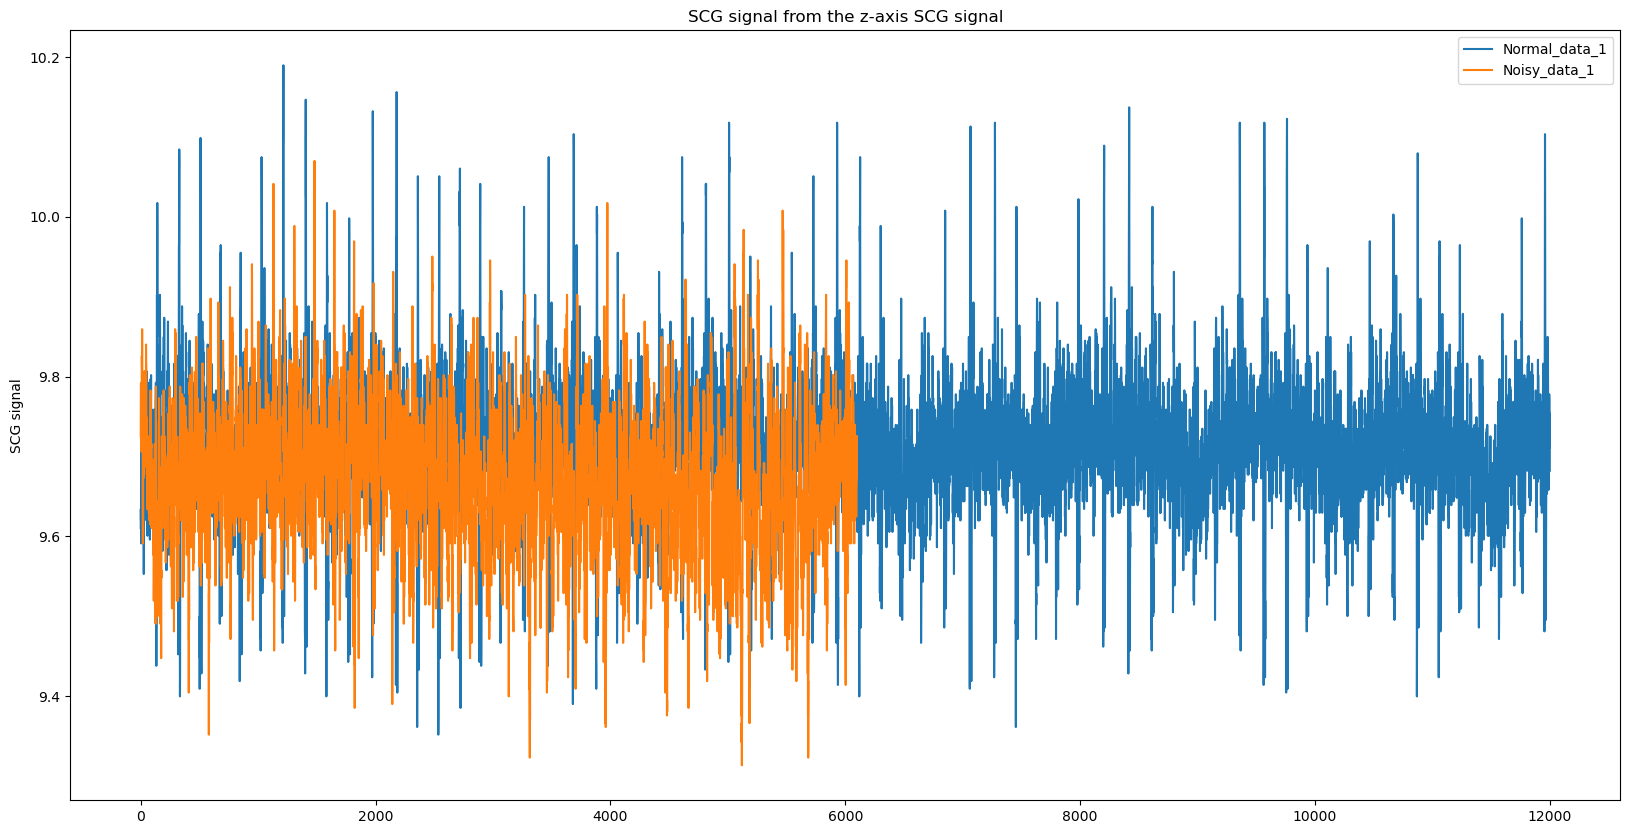

dataset/Normal_data_4.txt 12000
dataset/Noisy_data_4.txt 6700
dataset/Normal_data_2.txt 12000
dataset/Noisy_data_2.txt 6199
dataset/Noisy_data_3.txt 7300
dataset/Normal_data_3.txt 14000
dataset/Normal_data_1.txt 12000
dataset/Noisy_data_1.txt 6099


In [35]:
#Plot the z-axis SCG signal from the file "Noisy_data_1.txt" and plot the z-axis SCG signal from the file "Normal_data_1.txt" 

plt.figure(figsize=(20,10))
plt.plot(z_axis_data['Normal_data_1.txt'], label='Normal_data_1')
plt.plot(z_axis_data['Noisy_data_1.txt'], label='Noisy_data_1')
# add title and axis labels
plt.title('SCG signal from the z-axis SCG signal')
plt.ylabel('SCG signal')
plt.legend()
plt.show()


#check length of all the files
for data_file in dataFiles:
    df = pd.read_csv(data_file, sep=' ', header=None)
    print(data_file, len(df))

### - Observations

It is visible how all the noisy data have around half the lenght than the normal data does. This was seen in the graph and then checked with the rest of the files, and with all the same occurs. We can also observe better the periodicity of the SCG signal in the case of the normal data, which should be one of the characteristics of a SCG signal. 

The noise could be cause by floor vibrations, speaking or coughing of the patient between others. Also it is quite dependent on the placement of the smartphone wether the noise will be higher or less.

# Data Segmentation 
* Here is a simple function to use for data segmentation
* Segment the Z-axis signals into 5-second segments
* The sampling frequency used to record these signals is 200 Hz.
* Store the segments and the accompanying labels

In [36]:
#code (provided)

def _slicing(sig, file_label, segment_length = 1000):
    
    """
    inputs:
    sig : input array to be segmented
    file_label : label to be applied to segmented signal
    segment_length : Length in samples of the segments produced from the input signal
    
    outputs:
    sig_sliced : a list of segments
    label : a list of corresponding labels for the segmented signal 
    
    """

    sig_sliced = []
    label = []
    
    # slicing 
    
    for i in np.arange(int(len(sig)/segment_length)):

        sig_sliced.append( sig[i*segment_length:(i+1)*segment_length] )

        label.append(file_label)
        
    return (sig_sliced , label)


# Feature Extraction Function Creation
*  Define a function and name it “feature_extraction” in which you compute and return the features listed below
    * *Time Domain Features*:  mean, standard deviation, interquartile-range, median, peak-to-peak range, skewness, kurtosis, and root mean square. 
    * *Frequency Domain Features*: power spectral density (using welch function of scipy)
    
        * For power spectral density, Calculate the total power spectral density within frequency bins of 4 Hz steps. Discard the frequencies above 40 Hz. Get the power within each bin.
    
        Hint:
        
        Reference: https://docs.scipy.org/doc/scipy/reference/stats.html for skewness, kurtosis, interquartile-range(iqr)
        
        Reference: https://numpy.org/doc/stable/reference/routines.statistics.html for other time domain features
        
        Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html for transforming to zero mean and unit variance



In [49]:
from sklearn.preprocessing import scale

#code
def feature_extraction(sig, fs = 200):
    
    """
    inputs:
    sig : input array to extract features from
    fs : sampling frequency of input array

    
    outputs:
    feature_array: an array containing all the features extracted from the signal 
    """
    
    feature_array = {}

    ########################################## statistical features - time domain
    
    feature_array['mean'] = np.mean(sig)
    feature_array['std'] = np.std(sig)
    feature_array['iqr'] = stats.iqr(sig)
    feature_array['median'] = np.median(sig)
    feature_array['peak_to_peak'] = np.ptp(sig)
    feature_array['skewness'] = stats.skew(sig)
    feature_array['kurtosis'] = stats.kurtosis(sig)
    feature_array['rms'] = np.sqrt(np.mean(np.square(sig)))
    
    
    ########################################## PSD 
    
    # transforming to zero mean and unit variance -- only do this when extracting PSD
    # Hint: transfromed_sig = function_for_scale(sig)

    scaled_sig = scale(sig)

    frequencies , PSD = signal.welch(scaled_sig, fs) 
    
    freqs_arr = np.arange(0,41,4)
    
    PSD_binned_sum = [] 
    
    for i in range(freqs_arr.shape[0]-1): 
        
        PSD_binned_sum.append(np.sum(PSD[np.where( (frequencies >= freqs_arr[i] ) & 
                                                   ( frequencies < freqs_arr[i+1] ) )]))
    
    feature_array['PSD_0_4'] = PSD_binned_sum[0]
    feature_array['PSD_4_8'] = PSD_binned_sum[1]
    feature_array['PSD_8_12'] = PSD_binned_sum[2]
    feature_array['PSD_12_16'] = PSD_binned_sum[3]
    feature_array['PSD_16_20'] = PSD_binned_sum[4]
    feature_array['PSD_20_24'] = PSD_binned_sum[5]
    feature_array['PSD_24_28'] = PSD_binned_sum[6]
    feature_array['PSD_28_32'] = PSD_binned_sum[7]
    feature_array['PSD_32_36'] = PSD_binned_sum[8]
    feature_array['PSD_36_40'] = PSD_binned_sum[9]

    #feature_array['PSD_binned_sum'] = np.array(PSD_binned_sum)
        
    
    # return the feature array
    return feature_array



# Feature Extraction Application

* You must first segment your signals and then extract features from each segment. You could do it in the following way:



* Call the _slicing function to section all the z-axis data into 5-second segments
        Hint: Load each file in "dataFiles" with for-loop
* Use the feature extraction function you created and extract features from every segment that you have obtained.
* Store the labels and the features you extracted from each segment to numpy arrays. 
        Hint: Think of an easy way to extract the label "noisy" or "normal" from each file name
        str.split() could be used somehow in this case

In [50]:
n_samples = 5 * fs # find the number of samples for the 5 second segment

segment_data = []

for i, col_name in enumerate(z_axis_data):
    z_data = z_axis_data[col_name]
    sliced_data, sliced_labels = _slicing(z_data, col_name, segment_length=n_samples)
    
    for segment in sliced_data:

        # Nan values, fix so that for the noisy data the nan values are deleted or ignored
        if np.all(np.isnan(segment)):
            continue 
        else:
            segment = segment[~np.isnan(segment)]

        features = feature_extraction(segment)
        
        if "Normal" in col_name:
            label = "normal"
        elif "Noisy" in col_name:
            label = "noisy"

        segment_features = {"Label": label}
        segment_features.update(features)
        segment_data.append(segment_features)
        
features_df = pd.DataFrame(segment_data) # create a datagrame where the first column (label) has wether its noisy or normal and then each column is a feature

/Users/annafernandezrajal/miniconda3/envs/venv/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 199, using nperseg = 199
  .format(nperseg, input_length))
/Users/annafernandezrajal/miniconda3/envs/venv/lib/python3.7/site-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 99, using nperseg = 99
  .format(nperseg, input_length))


# Standardize Features
Hint:

    Use sklearn.preprocessing.scale() to standardize the features
    Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

In [51]:
labels = features_df['Label']
features = features_df.drop(columns=['Label']) # 'PSD_binned_sum'

standardized_features = pd.DataFrame(scale(features), columns=features.columns)

#standardized_features['PSD_binned_sum'] = features_df['PSD_binned_sum']
features_df_standardized = pd.concat([labels, standardized_features], axis=1)


# Principal Component Analysis
* Principal Component Analysis (PCA) is used to reduce the dimensionality of a data set consisting of many variables correlated with each other. This can then be used to visualize the data in a more practical way. 
* Compute the first and 2nd principal components
* Plot the two components on a scatter plot with the coloring done by label
* Are these features useful to seperate the two types of signals (noisy vs normal)?
* Describe your observations.
    
        Hint:
        my_pca=PCA(n_components=2)
        pca_out = my_pca.fit_transform(input)

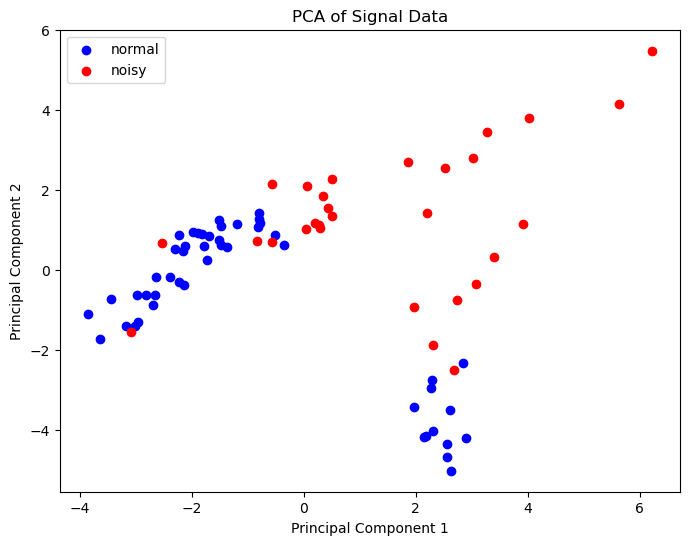

In [52]:
my_pca = PCA(n_components=2)
pca_out = my_pca.fit_transform(features_df_standardized.drop(columns=['Label']))# 'PSD_binned_sum'

pca_df = pd.DataFrame(data=pca_out, columns=['PC1', 'PC2'])
pca_df['Label'] = features_df_standardized['Label']

colors = {'normal': 'blue', 'noisy': 'red'}

plt.figure(figsize=(8, 6))
for label, color in colors.items():
    subset = pca_df[pca_df['Label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], c=color, label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Signal Data')
plt.legend()
plt.show()


# Observations 

Theres some decisions that were taken without it being specified, that should be checked:

--> remove the nans from noisy signal and segments, if the segment was all nan it was removed, and if it had some values, then the features of only those were computed
--> For the PSD there was the option to not pass as a parameter the fs so then only the first component had values, adn we can work with that as a feature. If we pass the fs then we get an arrray of binned PSD and then it is hard to work with and to standarize for the PCA, but if we instead save each fo the bins as a feature we get the shown reasult now.